# Explorative Data Analysis
## Important: This notebook is only used to perform the exploration data analysis. It does NOT contain the finalized model and training results. Please refer to finalized_model.ipynb for the finalized model.

In [1]:
import os
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import tqdm
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
ps = PorterStemmer()

### Define some useful functions

In [2]:
def load_data(split_name):
    df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
    print('loading data:',split_name,'\t length:',len(df))
    return df

def lower(s):
    if isinstance(s, list):
        return [lower(t) for t in s]
    if isinstance(s, str):
        return s.lower()
    else:
        raise NotImplementedError("unknown datatype")

def tokenize(text):
    return nltk.word_tokenize(text)

def stem(tokens):
    return [ps.stem(token) for token in tokens]

def n_gram(tokens, n=1):
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results

def filter_stopwords(tokens):
    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

def get_onehot_vector(feats, feats_dict):
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

def tfidf_tokenizer(text):   
    tokens = nltk.word_tokenize(text) # tokenize
    tokens = [token for token in tokens if token not in stopwords and not token.isnumeric()] # filter stopword
    stemmed = [ps.stem(token) for token in tokens]  # stem  
    return list(map(lambda x: lower(x), stemmed)) # lower

def tfidf_tokenizer_1(text):   
    tokens = nltk.word_tokenize(text) # tokenize
    return tokens

def tfidf_tokenizer_2(tokens):
    tokens = [token for token in tokens if token not in stopwords and not token.isnumeric()] # filter stopword
    stemmed = [ps.stem(token) for token in tokens]  # stem  
    return list(map(lambda x: lower(x), stemmed)) # lower

def isAdj(token):
    for token in nlp(token):
        return token.pos_ == 'ADJ'

def get_unla(tokens): # un-stem, non-stop, lower-case adjectives
    tokens = [token for token in tokens if token not in stopwords and not token.isnumeric()] # filter stopword
    tokens = [token for token in tokens if isAdj(token)] # get adjectives only
    return list(map(lambda x: lower(x), tokens))

def list_all_caps(tokens):
    new_list = []
    for token in tokens:
        if token.isalpha() and token.upper() == token and token.upper() not in ['I','A']:
            new_list.append(token.lower())
    return new_list

def count_tokens(tokens):
    return len(tokens)

def count_excl_quest(tokens):
    count = 0
    for token in tokens:
        if token == '!' or token == '?':
            count += 1
    return count

In [3]:
def get_new_df(mode):
    df = load_data(mode)
    # Adding day_of_week {0: Monday, 1:Tuesday,...} and isHoliday {1, 0}
    df['day_of_week'] = pd.to_datetime(df['date']).dt.weekday
    
    # Getting if the date is the holiday
    cal = calendar()
    holidays = cal.holidays()
    df['holiday'] = df['date'].isin(holidays)
    weekend = [6,7]
    df['holiday'] = df['day_of_week'].isin(weekend)
    # Changing True to 1, False to 0
    df['holiday'] = df['holiday'].map({True: 1, False: 0})
    
    # Other trial columns
    df['num_of_capital']=df['text'].str.findall(r'[A-Z]').str.len()
    df['raw_tokens'] = df['text'].map(tfidf_tokenizer_1)
    df['tokens'] = df['raw_tokens'].map(tfidf_tokenizer_2)
    df['numwords'] = df['raw_tokens'].map(tfidf_tokenizer_2).map(len)
    df['all_caps'] = df['raw_tokens'].map(list_all_caps)
    df['count_all_caps'] = df['all_caps'].map(len)
    df['excl_quest'] = df['tokens'].map(count_excl_quest)
    
    return df

### Load the data with all columns (including derived columns)

In [4]:
train_df = get_new_df('train')
valid_df = get_new_df('valid')
test_df = get_new_df('test')

loading data: train 	 length: 10000
loading data: valid 	 length: 2000
loading data: test 	 length: 2000


### Number of "all-caps" Words 
It has no clear relationship with stars as visualized

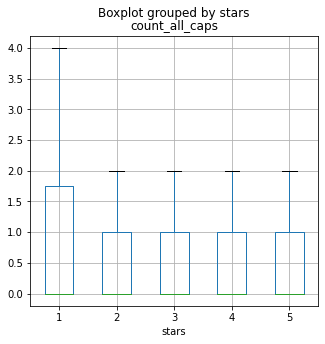

In [5]:
import numpy as np
train_df.boxplot(column= ['count_all_caps'], by ='stars', figsize=(5,5), showfliers= False)
plt.show()

### Number of Tokens
Here we observe a weak relationship between number of tokens and stars. However, we abandoned this column after finding out that number of characters convey more useful information and yield better validation accuracy.

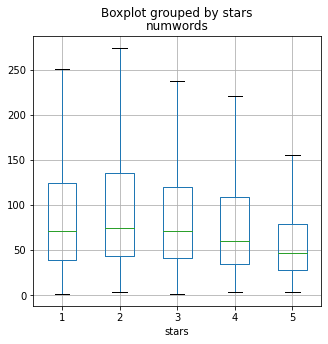

In [6]:
train_df.boxplot(column= ['numwords'], by ='stars', figsize=(5,5), showfliers= False)
plt.show()

### More Trials on Scatters
We try to see if there are useful relationships between columns

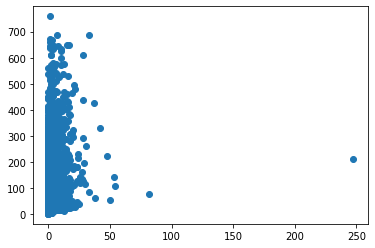

In [7]:
plt.scatter(train_df['useful'], train_df['numwords'])
plt.show()

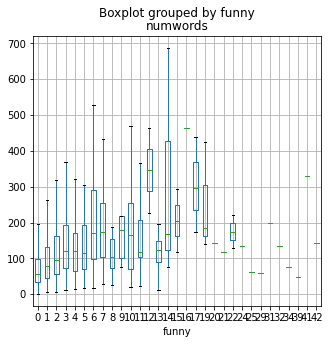

In [8]:
train_df.boxplot(column= ['numwords'], by ='funny', figsize=(5,5), showfliers= False)
plt.show()

c:\users\ymym\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


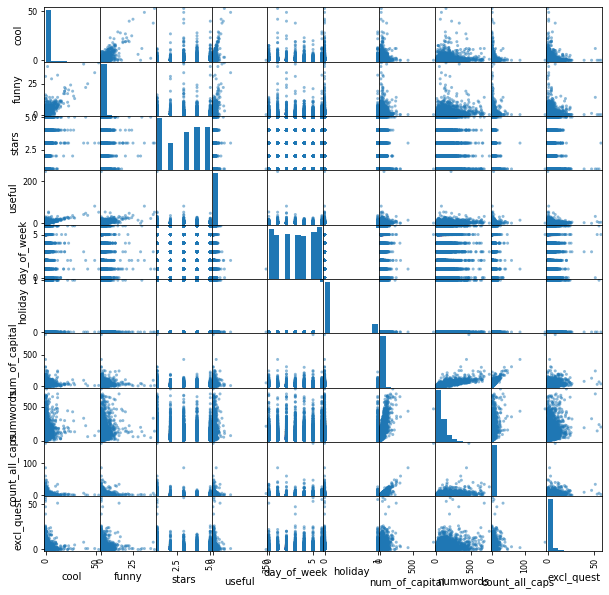

In [9]:
pd.plotting.scatter_matrix(train_df,figsize=(10,10))
plt.show()

### We also tried to group data by stars

star: 1


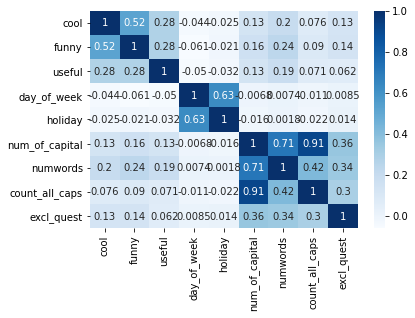

star: 2


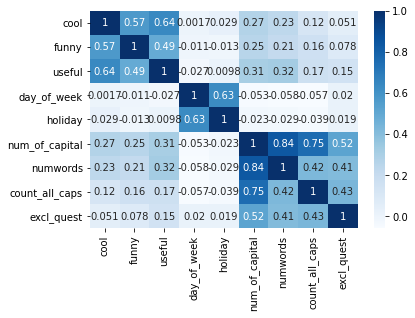

star: 3


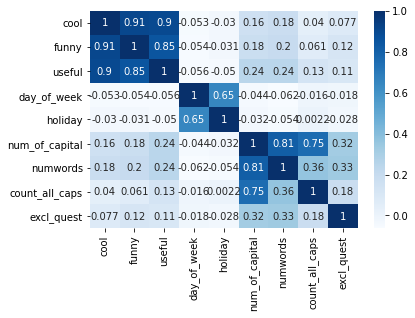

star: 4


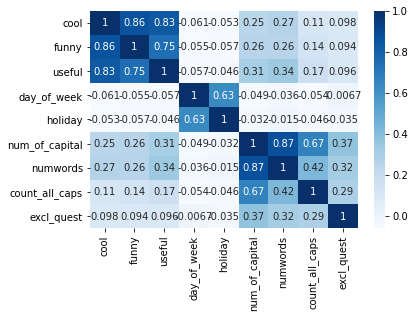

star: 5


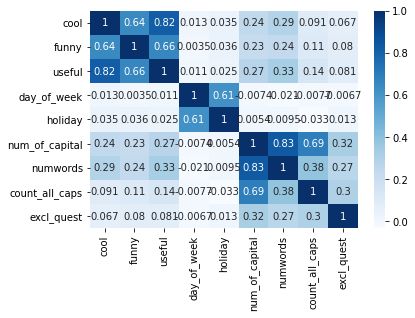

In [10]:
for star, sub_df in train_df.groupby('stars'):
    print(f"star: {star}")
    filtered_df=sub_df.loc[:,sub_df.columns!="stars"]
    corr = filtered_df.corr()
    sns.heatmap(corr, annot=True, cmap="Blues",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
    plt.show()

### Matrix showing the correlation between different columns
Some are abandoned later. Note that 'positivity' and 'hour' is not included here but only in abandoned_variation.ipynb .

In [11]:
stars_corr = train_df.corr()
stars_corr.style.background_gradient(cmap='coolwarm')

,cool,funny,stars,useful,day_of_week,holiday,num_of_capital,numwords,count_all_caps,excl_quest
cool,1.000000,0.735803,0.087558,0.542500,-0.032364,-0.014119,0.146721,0.190484,0.036493,0.060244
funny,0.735803,1.000000,-0.061346,0.507746,-0.037347,-0.016557,0.192471,0.228510,0.089075,0.095789
stars,0.087558,-0.061346,1.000000,-0.085296,-0.009572,-0.015927,-0.134026,-0.151242,-0.135625,-0.012370
useful,0.542500,0.507746,-0.085296,1.000000,-0.037780,-0.022639,0.202611,0.245023,0.106921,0.080886
day_of_week,-0.032364,-0.037347,-0.009572,-0.037780,1.000000,0.631051,-0.023717,-0.027095,-0.017169,0.000433
holiday,-0.014119,-0.016557,-0.015927,-0.022639,0.631051,1.000000,-0.016319,-0.012327,-0.019045,-0.002438
num_of_capital,0.146721,0.192471,-0.134026,0.202611,-0.023717,-0.016319,1.000000,0.771118,0.823238,0.358596
numwords,0.190484,0.228510,-0.151242,0.245023,-0.027095,-0.012327,0.771118,1.000000,0.380737,0.308776
count_all_caps,0.036493,0.089075,-0.135625,0.106921,-0.017169,-0.019045,0.823238,0.380737,1.000000,0.287557
excl_quest,0.060244,0.095789,-0.012370,0.080886,0.000433,-0.002438,0.358596,0.308776,0.287557,1.000000


## Important Note:
### The codes below this point is only used to make trials on different combinations of columns. They are NOT finalized and does not provide our finalized predictions.
### Please refer to finalized_model.ipynb for the finalized model with only selected columns and features.

In [ ]:
tfidf = TfidfVectorizer(
            tokenizer = tfidf_tokenizer, 
            ngram_range=(1,4), 
            max_features= 150000, 
            min_df= 3,
            max_df= 0.9,
        )

In [ ]:
### Building the tfidf vector using training set
train_tfidf = tfidf.fit_transform(train_df['text'])

### Transform the valid set and test set using the tfidf built by training set
valid_tfidf = tfidf.transform(valid_df['text'])
test_tfidf = tfidf.transform(test_df['text'])

In [ ]:
train_tfidf_array = train_tfidf.toarray()
valid_tfidf_array = valid_tfidf.toarray()
test_tfidf_array = test_tfidf.toarray()

In [ ]:
train_df['text_len'] = train_df['text'].apply(lambda x: len(x))
valid_df['text_len'] = valid_df['text'].apply(lambda x: len(x))
test_df['text_len'] = test_df['text'].apply(lambda x: len(x))

In [ ]:
# Normalizing these columns of each dataset
train_df_copy = train_df.copy()
valid_df_copy = valid_df.copy()
test_df_copy = test_df.copy()

for column in ['funny', 'useful', 'cool', 'text_len', 'day_of_week']:
    train_df_copy[column] = train_df_copy[column] /train_df_copy[column].abs().max()
    valid_df_copy[column] = valid_df_copy[column] /valid_df_copy[column].abs().max()
    test_df_copy[column] = test_df_copy[column] /test_df_copy[column].abs().max()

train_df = train_df_copy
valid_df = valid_df_copy
test_df = test_df_copy

In [ ]:
### Stack up the numeric features for each dataset ###

# t = train_df['tfidf'].values.reshape(-1, 1)
f = train_df['funny'].values.reshape(-1, 1)
u = train_df['useful'].values.reshape(-1, 1)
l = train_df['text_len'].values.reshape(-1, 1)
# c = train_df['cool'].values.reshape(-1, 1)
d = train_df['day_of_week'].values.reshape(-1, 1)
train_numeric = np.hstack((f,u,l,d))

# t = valid_df['tfidf'].values.reshape(-1, 1)
f = valid_df['funny'].values.reshape(-1, 1)
u = valid_df['useful'].values.reshape(-1, 1)
l = valid_df['text_len'].values.reshape(-1, 1)
# c = valid_df['cool'].values.reshape(-1, 1)
d = valid_df['day_of_week'].values.reshape(-1, 1)

valid_numeric = np.hstack((f,u,l,d))

# t = valid_df['tfidf'].values.reshape(-1, 1)
f = test_df['funny'].values.reshape(-1, 1)
u = test_df['useful'].values.reshape(-1, 1)
l = test_df['text_len'].values.reshape(-1, 1)
# c = test_df['cool'].values.reshape(-1, 1)
d = test_df['day_of_week'].values.reshape(-1, 1)

test_numeric = np.hstack((f,u,l,d))

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Activation, Input, Add, Concatenate, LayerNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from keras.utils import to_categorical
from keras.regularizers import l2

In [ ]:
# Getting the labels
y_train = train_df['stars'].values -1
y_valid = valid_df['stars'].values -1

In [ ]:
# Changing the labels to one hot vectors
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

In [ ]:
class MyModel(tf.keras.Model):

#     def __init__(self, seq_length, vocab_size, embedding_size= 64):
    def __init__(self):
        super(MyModel, self).__init__()
#         self.embedding = layers.Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=seq_length)
        self.BiLSTM = layers.Bidirectional(
            layers.LSTM(10, return_sequences=False, dropout=0.5, 
                        recurrent_dropout=0.5, kernel_regularizer=l2(0.005), unit_forget_bias= True,
                       ), 
            merge_mode="ave"
        )
        self.dense1 = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.005), bias_regularizer=l2(0.005))
        self.dense2 = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.005), bias_regularizer=l2(0.005))
        self.dense3 = Dense(5, activation='softmax')
        self.nlp_dropout = Dropout(0.3)
        self.dropout = Dropout(0.5)
#         self.BN = BatchNormalization()
        self.LN = LayerNormalization()
        self.activation = Activation('relu')
        
    def call(self, inputs):
        nlp_input = inputs[0]
        numeric_input = inputs[1]
        nlp_input = tf.reshape(tensor= nlp_input, shape=(tf.shape(nlp_input)[0], 1, tf.shape(nlp_input)[-1]))
        nlp_input = self.BiLSTM(nlp_input)
        nlp_input = self.LN(nlp_input)
        nlp_input = self.nlp_dropout(nlp_input)
        x = layers.Concatenate()([nlp_input, numeric_input])
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.activation(x)
        x = self.dense2(x)
        x = self.dropout(x)
        x = self.activation(x)
        x = self.dense3(x)
        
        return x
    

In [ ]:
os.makedirs("models", exist_ok=True)

# model = MyModel(seq_length = train_tfidf_array.shape[1] , vocab_size = len(word2id)+1 , embedding_size = 64)
model = MyModel()

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate=5e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models","weights.h5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

def scheduler(epoch, lr):
    if(epoch % 20 == 0 and epoch != 0):
        return lr * 0.5
    return lr

scheduler = keras.callbacks.LearningRateScheduler(
    scheduler,
    verbose=0
)

np.random.seed(0)
tf.random.set_seed(0)

history = model.fit([train_tfidf_array, train_numeric], y_train,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=1,
                    callbacks=[checkpointer, earlystopping, scheduler])


model.load_weights(os.path.join("models", "weights.h5"))

train_score = model.evaluate([train_tfidf_array, train_numeric], y_train,
                             batch_size=100)

test_score = model.evaluate([valid_tfidf_array, valid_numeric], y_valid,
                            batch_size=100)

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="LSTM-training", color="orange", linestyle="dashed")
plt.plot(history.history["val_loss"], label="LSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="LSTM-training", color="orange", linestyle="dashed")
plt.plot(history.history["val_accuracy"], label="LSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
logits = model.predict([valid_tfidf_array, valid_numeric], batch_size=100)
# print(logits)
y_pred = np.argmax(logits, axis= -1)
y_true = valid_df['stars'] - 1
print(classification_report(y_true, y_pred))
conf = confusion_matrix(y_true, y_pred)
print(conf)

In [ ]:
sns.heatmap(conf, annot=True, cmap="YlGnBu")

# Use validation sets to evaluate

In [ ]:
# Getting the prediction
logits = model.predict([valid_tfidf_array, valid_numeric], batch_size=100)
y_pred = np.argmax(logits, axis= -1) + 1

# Produce and export the ans and pred csv files 
val_ans = pd.DataFrame({'stars': valid_df['stars'], 'review_id': valid_df['review_id']})
val_pred = pd.DataFrame({'stars': y_pred, 'review_id': valid_df['review_id']})

val_ans.to_csv('./data/ans.csv', index= False)
val_pred.to_csv('./data/pred.csv', index=False)

In [ ]:
%run evaluate.py

# Export test set prediction

In [ ]:
# Getting the prediction
logits = model.predict([test_tfidf_array, test_numeric], batch_size=100)
y_pred = np.argmax(logits, axis= -1) + 1

# Produce and export the ans and pred csv files 
test_pred = pd.DataFrame({'stars': y_pred, 'review_id': valid_df['review_id']})
test_pred.to_csv('./data/pred.csv', index=False)

In [ ]:
%run evaluate.py